# PMAP Comorbidity Info Feature Engineering
Created: January 6, 2023

This notebook generates binary flags of Elixhauser and Charlson comorbidity information of CHF hospital stays w/ ICU.\
Reference for the ICD-10 coding algorithm for both Elixhauser and Charlson comorbidities can be found here : https://pubmed.ncbi.nlm.nih.gov/16224307/

Author: Vina Ro

In [1018]:
# Import packages
import numpy as np
import pandas as pd
import time as time
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import datetime

In [1019]:
# Set filepath
file_path = Path('PMAP_Comorbidity.ipynb').resolve()
data_path = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-220607-no-ptsd')

In [1020]:
# Import data
# PMAP diagnosis data is included in encounter_dx.csv, hosp_billing_dx.csv, and problem_list.csv
enc_dx             = pd.read_csv(data_path / 'encounter_dx.csv', parse_dates = ['enc_contact_date'], usecols = ['osler_sid','pat_enc_csn_sid', 'icd10_code', 'enc_contact_date'])
CHF_hosp_icu_stays = pd.read_csv('CHF_hosp_icu_stays.csv', parse_dates = ['hosp_admsn_time','hosp_disch_time','in_time','out_time'])
hosp_billing       = pd.read_csv(data_path / 'hosp_billing_dx.csv', usecols = ['osler_sid', 'pat_enc_csn_sid','icd10_code'])
prob_list          = pd.read_csv(data_path / 'problem_list.csv', parse_dates = ['noted_date'], usecols = ['osler_sid','problem_list_id', 'icd10_code', 'noted_date'])       

## Functions

In [1021]:
def elix_comor(df_orig):
    '''
    This function adds 31 categories(columns) on a given dataframe that marks comorbidities according to the Elixhauser Comorbidity Index.
    '''
    df = df_orig.copy()  
    df = df.assign( 
        ECI_CHF = df.icd10_code.str.contains(r'I09.9|I1[13].0|I13.2|I25.5|I42.0|I43|I50|P29.0|I42.[5-9]'),                        # Congestive Heart Failure
        ECI_CA = df.icd10_code.str.contains(r'I44.[1-3]|I45.[69]|I4[7-9]|R00.[018]|T82.1|Z[49]5.0'),                              # Cardiac Arrhythmias
        ECI_VALVE = df.icd10_code.str.contains(r'A52.0|I0[5-8]|I09.[18]|I3[4-9]|Q23.[0-3]|Z95.[2-4]'),                            # Valvular Disease
        ECI_PULMCIRC = df.icd10_code.str.contains(r'I2[67]|I28.[089]'),                                                           # Pulmonary Circulation Disorders
        ECI_PERIVASC = df.icd10_code.str.contains(r'I7[01]|I73.[189]|I77.1|I79.[02]|K55.[189]|Z95.[89]'),                         # Peripheral Vascular Disorders
        ECI_HTN = df.icd10_code.str.contains(r'I10'),                                                                             # Hypertension, uncomplicated
        ECI_HTNCX = df.icd10_code.str.contains(r'I1[1235]'),                                                                      # Hypertension, complicated
        ECI_PARA = df.icd10_code.str.contains(r'G04.1|G11.4|G80.[12]|G81|G82|G83.[0-4]|G83.9'),                                   # Paralysis
        ECI_NEURO = df.icd10_code.str.contains(r'G1[0-3]|G2[0-2]|G25.[45]|G31.[289]|G32|G3[5-7]|G4[01]|G93.[14]|R47.0|R56'),      # Other Neurological Disorders
        ECI_CHRNLUNG = df.icd10_code.str.contains(r'I27.[89]|J4[0-7]|J6[0-7]|J68.4|J70.[13]'),                                    # Chronic Pulmonary Disease
        ECI_DM = df.icd10_code.str.contains(r'E1[0-4].[019]'),                                                                    # Diabetes, uncomplicated
        ECI_DMCX = df.icd10_code.str.contains(r'E10.[2-8]|E11.[2-8]|E12.[2-8]|E13.[2-8]|E14.[2-8]'),                              # Diabetes, complicated
        ECI_HYPOTHY = df.icd10_code.str.contains(r'E0[0-3]|E89.0'),                                                               # Hypothyroidism
        ECI_RENLFAIL = df.icd10_code.str.contains(r'I12.0|I13.1|N1[89]|N25.0|Z49.[0-2]|Z94.0|Z99.2'),                             # Renal Failure
        ECI_LIVER = df.icd10_code.str.contains(r'B18|I85|I86.4|I98.2|K70|K71.[17]|K71.[3-5]|K7[2-4]|K76.0|K76.[2-9]|Z94.4'),      # Liver Disease
        ECI_ULCER = df.icd10_code.str.contains(r'K25.[79]|K26.[79]|K27.[79]|K28.[79]'),                                           # Peptic Ulcer Disease, excluding bleeding
        ECI_AIDS = df.icd10_code.str.contains(r'B2[0-2]|B24'),                                                                    # AIDS/HIV
        ECI_LYMPH = df.icd10_code.str.contains(r'C8[1-5]|C88|C96|C90.[02]'),                                                      # Lymphoma
        ECI_METS = df.icd10_code.str.contains(r'C7[7-9]|C80'),                                                                    # Metastatic Cancer
        ECI_TUMOR = df.icd10_code.str.contains(r'C[0-1]|C2[0-6]|C3[0-4]|C3[7-9]|C4[01]|C43|C4[5-9]|C5[0-8]|C6[0-9]|C7[0-6]|C97'), # Solid tumor without metastasis
        ECI_ARTH = df.icd10_code.str.contains(r'L94.[013]|M0[568]|M12.[03]|M30|M31.[0-3]|M3[2-5]|M45|M46.[189]'),                 # Rheumatoid arthritis/collagen vascular diseases
        ECI_COAG = df.icd10_code.str.contains(r'D6[5-8]|D69.[13456]'),                                                            # Coagulopathy
        ECI_OBESE = df.icd10_code.str.contains(r'E66'),                                                                           # Obesity
        ECI_WGHTLOSS = df.icd10_code.str.contains(r'E4[0-6]|R63.4|R64'),                                                          # Weight loss
        ECI_LYTES = df.icd10_code.str.contains(r'E22.2|E8[67]'),                                                                  # Fluid and Electrolyte Disorders
        ECI_BLDLOSS = df.icd10_code.str.contains(r'D50.0'),                                                                       # Blood Loss Anemia
        ECI_ANEMDEF = df.icd10_code.str.contains(r'D50.[89]|D5[1-3]'),                                                            # Deficiency Anemia
        ECI_ALCOHOL = df.icd10_code.str.contains(r'F10|E52|G62.1|I42.6|K29.2|K70.[039]|T51|Z50.2|Z71.4|Z72.1'),                   # Alcohol Abuse
        ECI_DRUG = df.icd10_code.str.contains(r'F1[1-6]|F1[89]|Z71.5|Z72.2'),                                                     # Drug Abuse
        ECI_PSYCH = df.icd10_code.str.contains(r'F2[0234589]|F3[01].2|F31.5'),                                                    # Psychoses
        ECI_DEPRESS = df.icd10_code.str.contains(r'F20.4|F31.[3-5]|F3[23]|F34.1|F41.2|F43.2')                                     # Depression
    )
    return df

In [1022]:
def charl_comor(df_orig):
    '''
    This function adds 17 categories(columns) on a given dataframe that marks comorbidities according to the Charlson Comorbidity Index.
    '''
    df = df_orig.copy()
    df = df.assign(
        CCI_MYOCARD = df.icd10_code.str.contains(r'I2[12]|I25.2'),                                                             # Myocardial infarction
        CCI_CHF = df.icd10_code.str.contains(r'I09.9|I1[13].0|I13.2|I25.5|I42.0|I42.[5-9]|I43|I50|P29.0'),                     # Congestive heart failure
        CCI_PERIVASC = df.icd10_code.str.contains(r'I7[01]|I73.[189]|I77.1|I79.[02]|K55.[189]|Z95.[89]'),                      # Peripheral vascular disease
        CCI_CEREB = df.icd10_code.str.contains(r'G4[56]|H34.0|I6[0-9]'),                                                       # Cerebrovascular disease
        CCI_DEMEN = df.icd10_code.str.contains(r'F0[0-3]|F05.1|G30|G31.1'),                                                    # Dementia
        CCI_CHRNLUNG = df.icd10_code.str.contains(r'I27.[89]|J4[0-7]|J6[0-7]|J68.4|J70.[13]'),                                 # Chronic pulmonary disease
        CCI_RHEU = df.icd10_code.str.contains(r'M0[56]|M31.5|M3[2-4]|M35.[13]|M36.0'),                                         # Rheumatic disease
        CCI_ULCER = df.icd10_code.str.contains(r'K2[5-8]'),                                                                    # Peptic ulcer disease
        CCI_LIVER = df.icd10_code.str.contains(r'B18|K70.[0-39]|K71.[3457]|K73|K74|K76.[02-4]|K76.[89]|Z94.4'),                # Mild liver disease
        CCI_DM = df.icd10_code.str.contains(r'E1[0-4].[01689]'),                                                               # Diabetes without chronic complication
        CCI_DMCX = df.icd10_code.str.contains(r'E1[0-4].[2-57]'),                                                              # Diabetes with chronic complication
        CCI_HP = df.icd10_code.str.contains(r'G04.1|G11.4|G80.[12]|G8[12]|G83.[0-49]'),                                        # Hemiplegia or paraplegia
        CCI_RENLFAIL = df.icd10_code.str.contains(r'I12.0|I13.1|N0[35].[2-7]|N1[89]|N25.0|Z49.[0-2]|Z94.0|Z99.2'),             # Renal disease
        CCI_MAL = df.icd10_code.str.contains(r'C[01][0-9]|C2[0-6]|C3[0-47-9]|C4[0135-8]|C6[0-9]|C7[0-6]|C8[1-58]|C9[0-7]'),    # Any malignancy,including lymphoma and leukemia, except skin malignant neoplasm
        CCI_SEVLIVER = df.icd10_code.str.contains(r'I85.[09]|I86.4|I98.2|K70.4|K7[12].1|K72.9|K76.[5-7]'),                     # Moderate or severe liver disease
        CCI_TUMOR = df.icd10_code.str.contains(r'C7[7-9]|C80'),                                                                # Metastatic solid tumor
        CCI_AIDS = df.icd10_code.str.contains(r'B2[0-24]')                                                                     # AIDS/HIV
        )
    return df

### Concatenate all diagnosis information(icd10 codes) from 3 dataframes into 1
enc_dx + prob_list + hosp_billing -> df_all_icd10

In [1023]:
enc_dx.rename(columns = {'enc_contact_date':'date_of_enc'}, inplace = True)
prob_list.rename(columns = {'noted_date':'date_of_enc', 'problem_list_id':'pat_enc_csn_sid'}, inplace = True)

# Concatenate information from tables w/ diagnosis info, and drop duplicates where same ICU stay has same dx noted on same date 
all_dx = pd.concat([enc_dx, prob_list], axis = 0)
all_dx = all_dx.drop_duplicates().sort_values(['osler_sid','date_of_enc'])

# Merge w/ cohort
temp = pd.merge(left=CHF_hosp_icu_stays, right = all_dx[['osler_sid','icd10_code','date_of_enc']], how='left', on=['osler_sid'])

# Get instances where date_of_enc is between hospital admission and discharge time
merged_df_dx = temp[temp.date_of_enc.between(temp.hosp_admsn_time.dt.date, temp.hosp_disch_time.dt.date)].dropna(subset = ['icd10_code'])
merged_dx = merged_df_dx[['osler_sid','pat_enc_csn_sid','icd10_code']]
merged_dx.head()

,osler_sid,pat_enc_csn_sid,icd10_code
3,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I48.91
4,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,R06.82
5,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,R06.00
6,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I08.0
7,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,R06.82


In [1024]:
# Concatenate information for all 3 tables and drop duplicates where same ICU stay has same dx noted on same date
df_cohort_billing = hosp_billing[ (hosp_billing.pat_enc_csn_sid.isin(CHF_hosp_icu_stays.pat_enc_csn_sid)) & (hosp_billing.osler_sid.isin(CHF_unq_idx_icu_stays.osler_sid)) ]
df_all_icd10 = pd.concat([merged_dx, df_cohort_billing], axis = 0)
df_all_icd10.head()

,osler_sid,pat_enc_csn_sid,icd10_code
3,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I48.91
4,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,R06.82
5,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,R06.00
6,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I08.0
7,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,R06.82


### Generate binary flags for Elixhauser and Charlson Comorbidities

In [1025]:
df_elix = elix_comor(df_all_icd10).drop('icd10_code', axis = 1)
df_charl = charl_comor(df_all_icd10).drop('icd10_code', axis = 1)

df_elix = df_elix.groupby(['osler_sid','pat_enc_csn_sid'], as_index=False).any()
df_elix.loc[:, 'ECI_CHF':'ECI_DEPRESS'] = df_elix.loc[:, 'ECI_CHF':'ECI_DEPRESS'].astype(int)
df_charl = df_charl.groupby(['osler_sid','pat_enc_csn_sid'], as_index=False).any()
df_charl.loc[:, 'CCI_MYOCARD':'CCI_AIDS'] = df_charl.loc[:, 'CCI_MYOCARD':'CCI_AIDS'].astype(int)

In [1027]:
df_elix.head()

,osler_sid,pat_enc_csn_sid,ECI_CHF,ECI_CA,ECI_VALVE,ECI_PULMCIRC,ECI_PERIVASC,ECI_HTN,ECI_HTNCX,ECI_PARA,...,ECI_COAG,ECI_OBESE,ECI_WGHTLOSS,ECI_LYTES,ECI_BLDLOSS,ECI_ANEMDEF,ECI_ALCOHOL,ECI_DRUG,ECI_PSYCH,ECI_DEPRESS
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,1,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,1,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,1,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,1,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Calculate Elixhauser Comorbidity Scores
Using the van Walraven algorithm (range -19 [less likely for in-hospital death] to 89 [more likely for in-hospital death]) to calculate scores from the Elixhauser Comorbidity Index.

In [1028]:
keys = df_elix.columns[2:]
values = [7,5,-1,4,2,0,0,7,6,3,0,0,0,5,11,0,0,9,12,4,0,3,-4,6,5,-2,-2,0,-7,0,-3]
score_dict = dict(zip(keys, values))
print(score_dict)

elix_score = df_elix.iloc[:, 2:].mul(score_dict).sum(axis = 1)
df_elix['Score'] = elix_score
df_elix.head()

{'ECI_CHF': 7, 'ECI_CA': 5, 'ECI_VALVE': -1, 'ECI_PULMCIRC': 4, 'ECI_PERIVASC': 2, 'ECI_HTN': 0, 'ECI_HTNCX': 0, 'ECI_PARA': 7, 'ECI_NEURO': 6, 'ECI_CHRNLUNG': 3, 'ECI_DM': 0, 'ECI_DMCX': 0, 'ECI_HYPOTHY': 0, 'ECI_RENLFAIL': 5, 'ECI_LIVER': 11, 'ECI_ULCER': 0, 'ECI_AIDS': 0, 'ECI_LYMPH': 9, 'ECI_METS': 12, 'ECI_TUMOR': 4, 'ECI_ARTH': 0, 'ECI_COAG': 3, 'ECI_OBESE': -4, 'ECI_WGHTLOSS': 6, 'ECI_LYTES': 5, 'ECI_BLDLOSS': -2, 'ECI_ANEMDEF': -2, 'ECI_ALCOHOL': 0, 'ECI_DRUG': -7, 'ECI_PSYCH': 0, 'ECI_DEPRESS': -3}


,osler_sid,pat_enc_csn_sid,ECI_CHF,ECI_CA,ECI_VALVE,ECI_PULMCIRC,ECI_PERIVASC,ECI_HTN,ECI_HTNCX,ECI_PARA,...,ECI_OBESE,ECI_WGHTLOSS,ECI_LYTES,ECI_BLDLOSS,ECI_ANEMDEF,ECI_ALCOHOL,ECI_DRUG,ECI_PSYCH,ECI_DEPRESS,Score
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,20
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,1,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,17
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,1,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,14
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,1,0,1,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,15
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,1,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,20


In [1029]:
temp = pd.merge(left = CHF_hosp_icu_stays, right = df_elix, how = 'left', on = ['osler_sid','pat_enc_csn_sid'])
df_comor_features = pd.merge(left = temp, right = df_charl, how = 'left', on = ['osler_sid','pat_enc_csn_sid'])
df_comor_features.to_csv('comorbidity_features.csv', index = False)

## Data Visualization
### 1. Prevalence of Elixhauser Comorbidities in our cohort

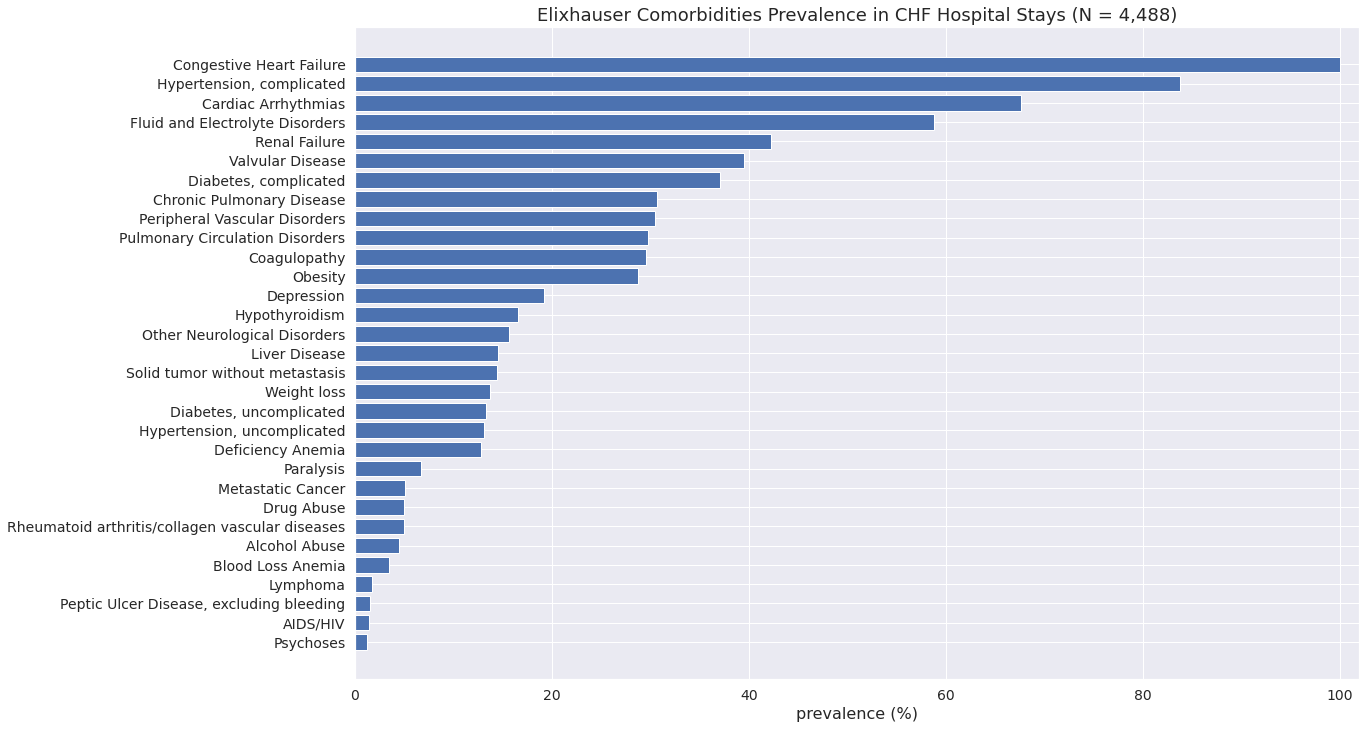

In [1030]:
keys = ['Congestive Heart Failure','Cardiac Arrhythmias','Valvular Disease','Pulmonary Circulation Disorders','Peripheral Vascular Disorders','Hypertension, uncomplicated','Hypertension, complicated',
        'Paralysis','Other Neurological Disorders','Chronic Pulmonary Disease','Diabetes, uncomplicated','Diabetes, complicated','Hypothyroidism','Renal Failure','Liver Disease',
        'Peptic Ulcer Disease, excluding bleeding','AIDS/HIV','Lymphoma','Metastatic Cancer','Solid tumor without metastasis','Rheumatoid arthritis/collagen vascular diseases','Coagulopathy','Obesity',
        'Weight loss','Fluid and Electrolyte Disorders','Blood Loss Anemia','Deficiency Anemia','Alcohol Abuse','Drug Abuse','Psychoses','Depression']
df = pd.DataFrame()
df['disease'] = keys
df['count'] = df_comor_features.loc[:, 'ECI_CHF':'ECI_DEPRESS'].sum().values/4488*100
df = df.sort_values('count')

sns.set_theme()
plt.figure(figsize = (18,12))
plt.barh(df['disease'],df['count'])
plt.title('Elixhauser Comorbidities Prevalence in CHF Hospital Stays (N = 4,488)', fontsize = 18)
plt.xlim([0, 102])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('prevalence (%)',fontsize = 16)
plt.show()

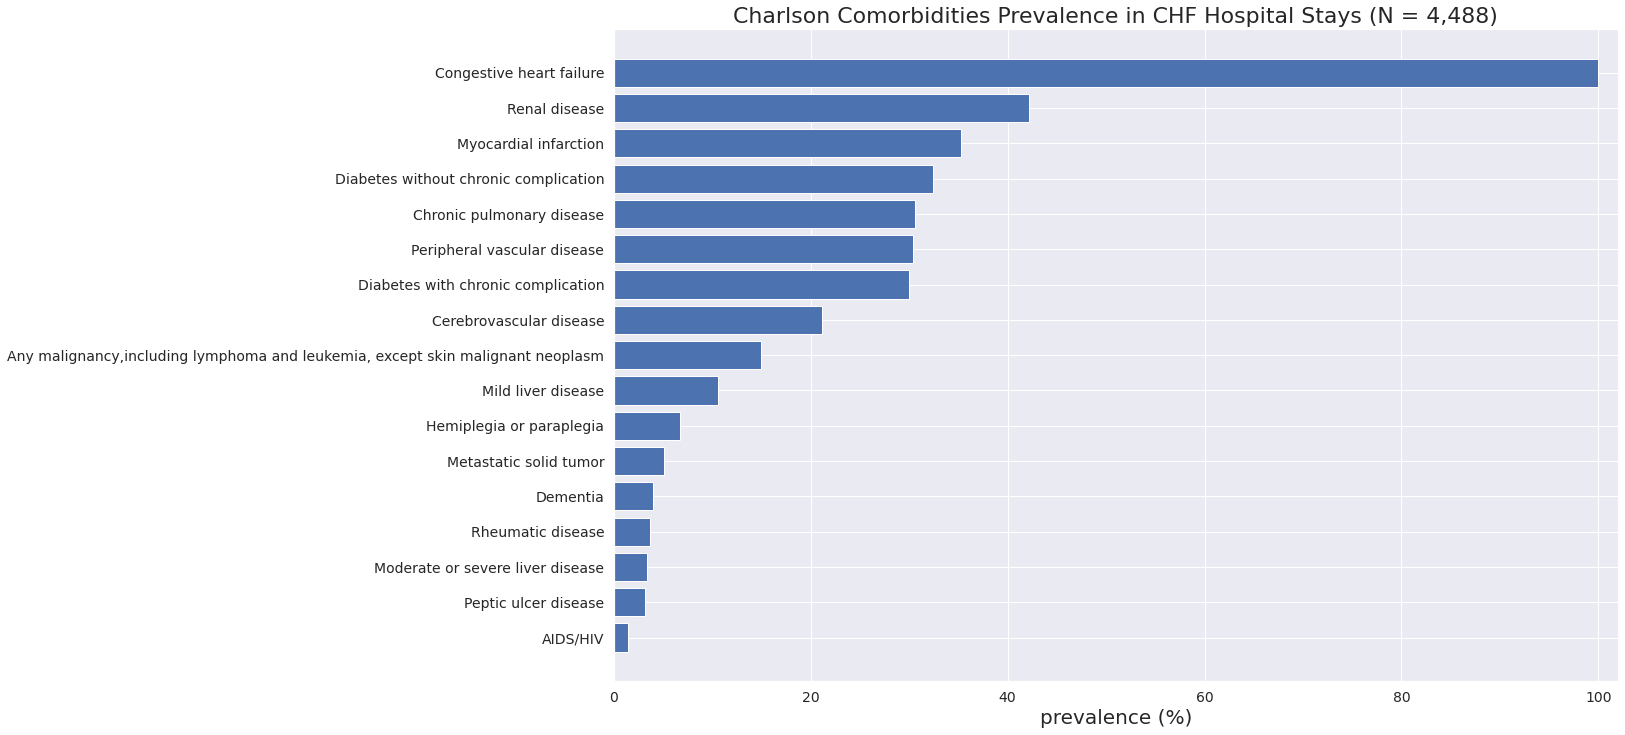

In [1035]:
keys = ['Myocardial infarction','Congestive heart failure','Peripheral vascular disease','Cerebrovascular disease','Dementia','Chronic pulmonary disease','Rheumatic disease','Peptic ulcer disease',
        'Mild liver disease','Diabetes without chronic complication','Diabetes with chronic complication','Hemiplegia or paraplegia','Renal disease',
        'Any malignancy,including lymphoma and leukemia, except skin malignant neoplasm','Moderate or severe liver disease','Metastatic solid tumor','AIDS/HIV']

df = pd.DataFrame()
df['disease'] = keys
df['count'] = df_comor_features.loc[:, 'CCI_MYOCARD':'CCI_AIDS'].sum().values/4488*100
df = df.sort_values('count')

plt.figure(figsize = (18,12))
plt.barh(df['disease'],df['count'])
plt.title('Charlson Comorbidities Prevalence in CHF Hospital Stays (N = 4,488)', fontsize = 22)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('prevalence (%)',fontsize = 20)
plt.xlim([0, 102])
plt.show()

### 2. Distribution of Elixhauser scores for both labels in our cohort

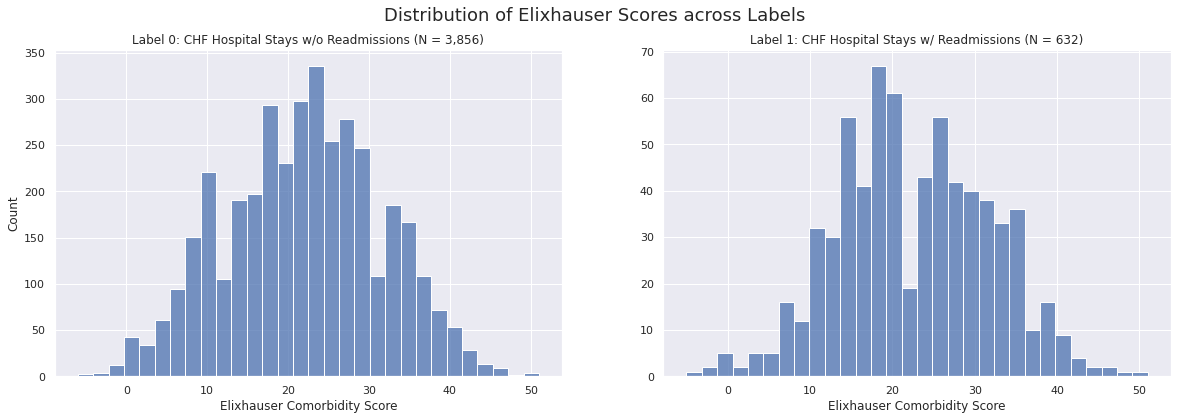

Mean of score for label 0: 21.912917653249146
Median of score for label 0: 22.0
STD of score for label 0: 9.585160896203652
Mean of score for label 1: 22.625909752547308
Median of score for label 1: 22.0
STD of score for label 1: 9.349144330781884


In [1032]:
df_comor_features_hosp_label_0 = df_comor_features_hosp[df_comor_features_hosp.labels == 0]
df_comor_features_hosp_label_1 = df_comor_features_hosp[df_comor_features_hosp.labels == 1]

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.histplot(data=df_comor_features_hosp_label_0, x="Score", bins = 30)
plt.title('Label 0: CHF Hospital Stays w/o Readmissions (N = 3,856)')
#plt.ylim([0, 2700])
plt.xlabel('Elixhauser Comorbidity Score')

plt.subplot(1,2,2)
sns.histplot(data=df_comor_features_hosp_label_1, x="Score", bins = 30)
#plt.ylim([0, 2700])
plt.xlabel('Elixhauser Comorbidity Score')
plt.ylabel('')
plt.title('Label 1: CHF Hospital Stays w/ Readmissions (N = 632)')

plt.suptitle('Distribution of Elixhauser Scores across Labels', fontsize = 18)
plt.show()

print('Mean of score for label 0: ' + str(df_comor_features_hosp_label_0.Score.mean()))
print('Median of score for label 0: ' + str(df_comor_features_hosp_label_0.Score.median()))
print('STD of score for label 0: ' + str(df_comor_features_hosp_label_0.Score.std()))
print('Mean of score for label 1: ' + str(df_comor_features_hosp_label_1.Score.mean()))
print('Median of score for label 1: ' + str(df_comor_features_hosp_label_1.Score.median()))
print('STD of score for label 1: ' + str(df_comor_features_hosp_label_1.Score.std()))